# Variational Quantum Eigensolver (using HWE, SPSA)

By Anna Payne

In [72]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, visualize_transition
from qiskit.circuit.library import RealAmplitudes # Common VQE Ansantze
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_algorithms import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SLSQP, SPSA
from qiskit.circuit.library import UGate
from qiskit.quantum_info import SparsePauliOp, Operator

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from random import random

This code takes reference from 
https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb

but updates all outdated Qiskit references and changed ansatz choices, classical optimizer, and corresponding math. 

In [73]:
# # Loading your IBM Q account(s)
# IBMQ.load_account()
# provider = IBMQ.get_provider(hub = 'ibm-q')

## Hamiltonian 
expressed as sum of tensor products of pauli operators
$ H = 0.4IX + 0.6IZ + 0.8XY$

For a given $\ket{\psi}$ we want to measure the expectation value of H: 

$ H = \bra{\psi}A\ket{\psi} =  0.4 \bra{\psi}IX\ket{\psi} + 0.6 \bra{\psi}IZ\ket{\psi} + 0.8 \bra{\psi}XY\ket{\psi}$

Over several trials in this algorithm, a parameterized quantum circuit is constructed for each Pauli term and computes its expectation value, then summed to obtain H. Each trial uses a different wavefunction (ansatz) $\ket{\psi}$, of which the smallest expectation value corresponds to the eigenvector of H with the smallest eigenvalue. 

In [74]:
def hamiltonian_operator(a, b, c, d):
    #Creates a*I + b*Z + c*X + d*Y pauli sum = Hamiltonian operator.
    pauli_list = [("I", a),("Z", b),("X", c),("Y", d)]
    
    return SparsePauliOp.from_list(pauli_list)


#creating a,b,c,d from random real numbers bewtween [0,10]
scale = 10
a, b, c, d = (scale*random(), scale*random(), 
              scale*random(), scale*random())
H = hamiltonian_operator(a, b, c, d)

### Reference NumpyEigensolver
Use Qiskits NumpyMinimumEigensolver class to find the smallest eigenvalue of the given H with a classical algorithm to compare later with the VQE results. 

In [75]:
exact_result = NumPyMinimumEigensolver()
result = exact_result.compute_minimum_eigenvalue(operator=H)
reference_energy = result.eigenvalue.real
print('The exact ground state energy is: {}'.format(reference_energy))

The exact ground state energy is: -7.674582676463951


## Ansatz

Trial wavefunctions $\ket{\psi}$ that are created from parameterized circuit (by changing parameters, different wavefunctions are created), with a goal of obtaining the smallest eigenvector $\ket{\psi_g}$ that minimizes the expectation value of H (this corresponds with eigenvector of H that has smallest eigenvalue). 

$$
\left| \psi \right\rangle = \begin{pmatrix}
\cos{\left( \theta/2 \right)}\\
e^{i \varphi} \cdot \sin{\left( \theta/2 \right)}
\end{pmatrix}
$$

Where $\theta$ and $\varphi$ define the point on the 3D Bloch Sphere \. 

The parameters for ansatz states are controlled classically with optimization methods (SPSA) in order to create an ansatz with a smaller expectation value than the previous one. 

In this notebook, we are using a **Hardware Efficient Ansatz (HWE)**. 

Qubits states are represented as $$\ket{0} = \begin{pmatrix} 1\\0 \end{pmatrix}$$ This is their vertical position of vector in the Bloch Sphere. In order to generate $\ket{\psi}$ we apply ${R_z}(\theta)$ (rotation around the z-axis) and ${R_y}(\theta)$ (rotation around the y axis) to gates on the inital state $\ket{0}$ -> ${R_y}(\theta){R_z}(\theta)\ket{0} = \ket{\psi}$. These rotations (gates) give us access to any point on the Bloch Sphere. 

$$
R_z(\phi) = \begin{pmatrix}
e^{-i\phi/2} & 0 \\
0 & e^{i\phi/2}
\end{pmatrix}
$$

$$
R_y(\theta) = \begin{pmatrix}
\cos\left(\frac{\theta}{2}\right) & -\sin\left(\frac{\theta}{2}\right) \\
\sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right)
\end{pmatrix}.
$$

These two gates (with parameters $ \phi, \theta$) will generate the trial wavefunction.

Applying the sequence $R_z(\phi)R_y(\theta)$ to the initial ground state $|0\rangle$:
$$
|\psi\rangle = R_z(\phi)R_y(\theta) \begin{pmatrix} 1 \\ 0 \end{pmatrix}
$$

$$
|\psi\rangle = \begin{pmatrix} e^{-i\phi/2} & 0 \\ 0 & e^{i\phi/2} \end{pmatrix} \begin{pmatrix} \cos(\theta/2) & -\sin(\theta/2) \\ \sin(\theta/2) & \cos(\theta/2) \end{pmatrix} \begin{pmatrix} 1 \\ 0 \end{pmatrix}
$$

$$
|\psi\rangle = \begin{pmatrix} e^{-i\phi/2} \cos(\theta/2) \\ e^{i\phi/2} \sin(\theta/2) \end{pmatrix}
$$

To simplify into standard Bloch sphere representation,  factor out global phase of $e^{-i\phi/2}$. Since global phases do not affect the measurement probabilities/expectation values, they should be ommited: 
$$
|\psi\rangle = e^{-i\phi/2} \begin{pmatrix} \cos(\theta/2) \\ e^{i\phi} \sin(\theta/2) \end{pmatrix} \Rightarrow \begin{pmatrix} \cos(\theta/2) \\ e^{i\phi} \sin(\theta/2) \end{pmatrix}
$$

In [76]:
def quantum_state_preparation(circuit, parameters):
    circuit.ry(parameters[1], 0) # parameter[1] = phi
    circuit.rz(parameters[0], 0) # parameter[0] = theta
    return circuit


The single-qubit Pauli gates are defined as follows:

**Pauli-X (NOT Gate):**
$$
X = \begin{pmatrix} 
0 & 1 \\ 
1 & 0 
\end{pmatrix}
$$

**Pauli-Y Gate:**
$$
Y = \begin{pmatrix} 
0 & -i \\ 
i & 0 
\end{pmatrix}
$$

**Pauli-Z (Phase Flip Gate):**
$$
Z = \begin{pmatrix} 
1 & 0 \\ 
0 & -1 
\end{pmatrix}
$$

**Identity Matrix:**
$$
I = \begin{pmatrix} 
1 & 0 \\ 
0 & 1 
\end{pmatrix}
$$

If we are handling of a single qubit, we only use the 4 basic Pauli Operators (I, X, Y, Z). This quantum state is represented as: 

$ H = \bra{\psi}H\ket{\psi} =  a \bra{\psi}I\ket{\psi} + b \bra{\psi}Z\ket{\psi} + c \bra{\psi}X\ket{\psi} + d \bra{\psi}Y\ket{\psi}$
<br>

Considering the identity operator $I$, $\bra{\psi}I\ket{\psi} = \bra{\psi}\ket{\psi} = 1$ so therefore: 

$ H = \bra{\psi}A\ket{\psi} =  a + b \bra{\psi}Z\ket{\psi} + c \bra{\psi}X\ket{\psi} + d \bra{\psi}Y\ket{\psi}$

For the other Pauli operators: 
$$
\left| \psi \right\rangle = c_1^z \left| 0 \right\rangle + c_2^z \left| 1 \right\rangle = c_1^x \left| + \right\rangle + c_2^x \left| - \right\rangle = c_1^y \left| +i \right\rangle + c_2^y \left| -i \right\rangle
$$

where eigenvectors: 

$Z = \ket{0} = \begin{pmatrix} 1\\0 \end{pmatrix}, \ket{1} = \begin{pmatrix} 0\\1 \end{pmatrix}$ 

$X = \ket{+} = \frac{1}{\sqrt{2}} \begin{pmatrix} 1\\1 \end{pmatrix},   \ket{-} = \frac{1}{\sqrt{2}}\begin{pmatrix} 1\\-1 \end{pmatrix}$ 

$Y = \ket{+i} = \frac{1}{\sqrt{2}} \begin{pmatrix} 1\\i \end{pmatrix},   \ket{-i} = \frac{1}{\sqrt{2}}\begin{pmatrix} 1\\-i \end{pmatrix}$ 

The first column of each Pauli operator's eigenvectors above has an eigenvalue equal to +1 and the second equal to -1.  To calculate the expectation value of each of these: 

$\bra{\psi}Z\ket{\psi} = (c_1^{z*} \bra{0} + c_2^{z*} \bra{1}) Z(c_1^{z} \ket{0} + c_2^{z}  \ket{1}) = |c_1^{z}|^2 - |c_2^{z}|^2 $ 

$\bra{\psi}X\ket{\psi} = (c_1^{x*} \bra{+} + c_2^{x*} \bra{-}) X(c_1^{x*} \ket{+} + c_2^{x*} \ket{-}) = |c_1^{x}|^2 - |c_2^{x}|^2 $ 

$\bra{\psi}Y\ket{\psi} = (c_1^{y*} \bra{+i} + c_2^{y*}\bra{-i}) Y(c_1^{y*} \ket{+i} + c_2^{y*} \ket{-i}) = |c_1^{y}|^2 - |c_2^{y}|^2 $ 

while considering the inner product of orthonormal vectors is 0 ($\bra{0}\ket{1} = 0, \bra{+}\ket{-} = 0, \bra{+i}\ket{-i} = 0$). 

$|c_1^{z}|^2 - |c_2^{z}|^2$ and so on represent the probabilities after measurement the quantum state $\ket{\psi}$ will become $\ket{1}$ or $\ket{0}$. To find the value, we run the algorithm with the trial function $\ket{\psi}$ and do Z/X/Y measurement on the qubit $N$ times (shots), resulting in the probility of $\ket{0} = |c_1^{z}|^2 = \frac{n_0}{N}$, $\ket{1} = |c_2^{z}|^2 = \frac{n_1}{N}$, and so on. $n_0$ and $n_1$ equal the number of state measurements, meaning the final expectation value of Z would be $Z = \frac{n_0 - n_1}{N}$, X would be $X =  \frac{n_+ - n_-}{N}$, and Y is $\frac{n_{+i} - n_{-i}}{N}$. 



These operators are applied to the $\ket{\psi}$ state in order to tramsform $\ket{0}$ and $\ket{1}$ into equal quantum superpositions, allowing qubits to represent both states at once. 

$H_{gate}\ket{\psi} = H_{gate}(c_1^{x*} \ket{+} + c_2^{x*} \ket{-}) = c_1^{x} \ket{0} + c_2^{x} \ket{1}$. 

Y gate performs a simultaneous bit-flip and phase-flip on the qubit, mapping $\ket{0} -> i\ket{1}$ and $\ket{1} -> -i\ket{0}$. This means it rotates 180 around the Y-axis, while acting as its own inverse. 


$Y_{gate}\ket{\psi} = Y_{gate}(c_1^{y*} \ket{+i} + c_2^{y*} \ket{-i}) = c_1^{y} \ket{0} + c_2^{y} \ket{1}$. 

<br>

These are the matrix representations of these gates: 

$$
H = \frac{1}{\sqrt{2}} \begin{pmatrix} 
1 & 1 \\ 
1 & -1 
\end{pmatrix}
$$

$$
Y = \begin{pmatrix} 
0 & -i \\ 
i & 0 
\end{pmatrix}
$$



In [77]:
H_gate = Operator(UGate(np.pi/2, 0, np.pi)).data   #hadamard gate 
print("H_gate:")
print((H_gate * np.sqrt(2)).round(5))

Y_gate = Operator(UGate(np.pi/2, 0, np.pi/2)).data    
print("Y_basis_gate:")
print((Y_gate * np.sqrt(2)).round(5))

H_gate:
[[ 1.+0.j  1.-0.j]
 [ 1.+0.j -1.+0.j]]
Y_basis_gate:
[[ 1.+0.j -0.-1.j]
 [ 1.+0.j  0.+1.j]]


## VQE Circuit

This creates an ansatz circuit for optimization, using its speficic measurements (Z/X/Y)

In [78]:
def vqe_circuit(parameters, measure):
    """
    Creates ansatz circuit for optimization.
    param parameters: list of parameters to construct ansatz state.
    param measure: measurement type ('X', 'Y', or 'Z').
    """
    
    q = QuantumRegister(1, name="q")
    c = ClassicalRegister(1, name="c")
    circuit = QuantumCircuit(q, c)

    # quantum state preparation
    circuit = quantum_state_preparation(circuit, parameters)

    # measurement basis transformation
    if measure == 'Z':
        # Z-basis= default measurement basis
        circuit.measure(q[0], c[0])
        
    elif measure == 'X':
        # Hgate maps X-basis to Z-basis
        circuit.h(q[0])
        circuit.measure(q[0], c[0])

    elif measure == 'Y':    
        # S-dagger rotates Y to X  (sdg)
        # Hgate rotates X to X 
        circuit.sdg(q[0]) 
        circuit.h(q[0])
        circuit.measure(q[0], c[0])
    else:
        raise ValueError('Not valid input for measurement: input should be "X" or "Y" or "Z"')

    return circuit


This module finds the expectation value of a Pauli operators and returns it.

In [79]:
shots = 8192
backend = AerSimulator()

def quantum_module(parameters, measure):
    # I operator always has expect. value of 1
    if measure == 'I':
        return 1
    
    if measure in ['X', 'Y', 'Z']:
        circuit = vqe_circuit(parameters, measure)
    else:
        raise ValueError('Not valid input: input should be "I", "X", "Y", or "Z"')
    
    
    # Transpile the circuit for specific backend and run
    t_circuit = transpile(circuit, backend, optimization_level=0)     #set to 0 as this is a light computational load
    job = backend.run(t_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    expectation_value = 0
    for measure_result, count in counts.items():
        sign = 1 if measure_result == '0' else -1
        expectation_value += sign * (count / shots)
        
    return expectation_value

This function creates a dict from SparsePauliOperator object (the $H$ is encoded in the object).

In [80]:
def pauli_operator_to_dict(pauli_operator):
    """
    From a SparsePauliOp return a dict:
    {'I': 0.7, 'X': 0.6, 'Z': 0.1, 'Y': 0.5}.
    :param pauli_operator: qiskit.quantum_info.SparsePauliOp
    :return: a dict in the desired form.
    """

    labels = pauli_operator.paulis.to_labels()
    coeffs = pauli_operator.coeffs
    
    paulis_dict = {}
    for label, coeff in zip(labels, coeffs):
        paulis_dict[label] = coeff.real

    return paulis_dict

pauli_dict = pauli_operator_to_dict(H)
pauli_dict

{'I': np.float64(0.5764460430653606),
 'Z': np.float64(6.835297087304655),
 'X': np.float64(4.122273071241079),
 'Y': np.float64(2.0892710175806837)}

This final function takes the ansatz state preparation parameters as input and returns the corresponding expectation value of the $H$. For each Pauli term, there are seperate quantum modules calculating the expectation value of each Pauli, then all values are multiplied by their corresponding coefficients ($a,b,c,d$) are summed together. 

In [81]:
def vqe(parameters):
    """
    Calculates the total expectation value (energy) for the Hamiltonian.
    :param parameters: 1D array of parameters from the optimizer.
    :return: Total energy (float).
    """
    total_energy = 0
    
    # Iterate through the dict\
    for label, coefficient in pauli_dict.items():
        # Get expectaton value for specific Pauli string
        # <O> = coeff * <psi|O|psi>
        
        expectation_value = quantum_module(parameters, label)
        total_energy += coefficient * expectation_value
        
    return total_energy

Finally, minimize (optimize) the returned value from the vqe fucntion by modifying the parameters for quantum state preparation. 

The exact ground state energy is: -7.674583
The VQE estimated energy is:-7.650352
Accuracy Error: 0.024230


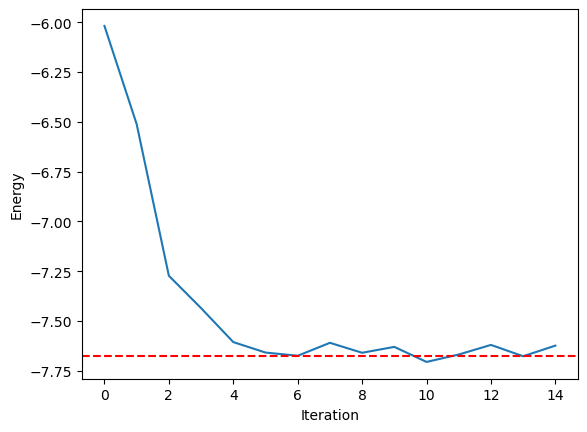

In [82]:
# parameters_array = np.array([np.pi, np.pi]).flatten()
# tol = 1e-3           # tolerance for optimization precision.

parameters_array = np.array([np.pi, np.pi])
energy_history = []

def callback(nfev, x_next, f_next, stepsize, accepted):
    energy_history.append(f_next)

spsa = SPSA(maxiter=15, callback=callback)

 
vqe_result = spsa.minimize(fun=vqe,     #handles statistical noise better than gradient based optimizers 
                           x0=parameters_array)


print(f'The exact ground state energy is: {reference_energy:.6f}')
print(f'The VQE estimated energy is:{vqe_result.fun:.6f}')
print(f'Accuracy Error: {abs(reference_energy - vqe_result.fun):.6f}')


plt.plot(energy_history, label='SPSA Optimization')
plt.axhline(y=reference_energy, color='r', linestyle='--', label='Exact Energy')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.show()